### Imports

In [8]:
import pandas as pd
import numpy as np

import re

from tqdm import tqdm
tqdm.pandas()

from collections import Counter

# nltk library imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [10]:
### Run nltk download command once to get required stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

stop = stopwords.words('english')
ps=PorterStemmer()

stackoverflow_stopwords = ["account" ,"also" ,"anoth" ,"apart" ,"behind" ,"better" ,"bother" ,"cant" ,"chang" ,"check" ,"come" ,"contain" ,"convert" ,"develop" ,"doesnt" ,"dont" ,"edit" ,"editor" ,"eg" ,"even" ,"exampl" ,"first" ,"follow" ,"friend" ,"get" ,"give" ,"given" ,"great" ,"happen" ,"help" ,"im" ,"ive" ,"know" ,"like" ,"list" ,"load" ,"love" ,"maintain" ,"need" ,"never" ,"often" ,"one" ,"put" ,"question" ,"rather" ,"right" ,"say" ,"see" ,"seem" ,"show" ,"someth" ,"take" ,"thank" ,"there" ,"thing" ,"think" ,"type" ,"use" ,"want" ,"way" ,"window" ,"without" ,"work" ,"would" ,"write"]

### Functions

In [11]:
def topn_tags(dataFrame ,n):
    """
    This function returns a list of top n tags 
    :param dataFrame: pandas dataFrame
    :param n: integer
    :returns: list of strings
    """
    dataFrame['Tags'] = dataFrame['Tags'].apply(lambda x : x.split(' '))
    
    counter = Counter()
    _ = df['Tags'].apply(counter.update)
    
    unique_tags = counter.most_common(n)       # Top n tags
    tags_df = pd.DataFrame(unique_tags, columns=['Tags','Freq'])
    unique_tags = tags_df.Tags.tolist()
    
    return unique_tags
    

def separate_code_and_body(body):
    """
    This function returns a list of two strings - Code and Description from the given Body content
    :param string: text string of body
    :returns: list of strings containing Code and Body
    """
    code_snippets = re.finditer("<code.*?>(.*?)</code>", body, re.DOTALL)
    code = []
    description = body
    for snip in code_snippets:
        code.append(snip.group())
        body = body.replace(snip.group(),"")
    return [code, body]  


def convert_to_lower(text):
    """
    This function returns a string with lowercase characters
    :param string: text string
    :returns: text string
    """
    return text.lower()

def remove_special_chars(text):
    """
    This function returns a string with filtered special case characters except # and ++ for C# and C++
    :param string: text string
    :returns: text string
    """
    return re.sub(r"[^A-Za-z #++]+",'', text)

def get_list_intersection(x, y):
    """
    This function returns a list which is intersection of two input lists
    :param list: list of strings
    :param list: list of strings
    :returns: Intersection list of strings
    """
    return list(set(x) & set(y))


def remove_html_tags(text):
    """
    This function returns a string after removing html tags from a string
    :param string: text string
    :returns: text string
    """
    clean = re.compile('<.*?>')
    return re.sub(clean,'', text)

def remove_n(text):
    """
    This function returns a string after removing new line char(\n) from a string
    :param string: text string
    :returns: text string
    """
    clean1 = re.compile('\n')
    return re.sub(clean1,'', text)

def get_processed_tags(tags, tag_ids, n):
    """
    This function returns a list of binary values of tags size length for tags represention
    :param list: list of tags
    :param Dictionary: Dict of tags and their ids
    :param int: Number of frequent tags
    :returns: text string
    """
    label = [0]*n
    for tag in tags:
        label[tag_ids[tag]] = 1
    return label

### Read Data

In [12]:
df = pd.read_csv('./../data/processed/train.csv', nrows=100000)

### Number of Most frequent tags taken into consideration
n = 10

### Data Pre - Processing

#### Tags Filtering

In [13]:
# Converting Tags to lower case
df['Tags'] = df['Tags'].progress_apply(lambda x: convert_to_lower(str(x)))

# Drop nan Tag values
df.dropna(subset=['Tags'],inplace=True)

# Filtering to Top 100 tags on Frequency
unique_tags = topn_tags(df,n)

# Filtering the Dataset for top 100 tags
df['Tags'] = df['Tags'].apply(lambda x : get_list_intersection(x,unique_tags))
df = df[df['Tags'].map(lambda d: len(d)) > 0]
df.reset_index(drop=True, inplace=True)

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 634113.24it/s]


#### Separate Code from Body

In [14]:
df['Code'] = df['Body'].progress_apply(lambda x : separate_code_and_body(x))
df[['Code','Description']] = pd.DataFrame(df.Code.tolist(), index= df.index)

100%|██████████████████████████████████| 44296/44296 [00:00<00:00, 57604.04it/s]


#### Convert to Lower

In [15]:
df['Title'] = df['Title'].progress_apply(lambda x:  convert_to_lower(x))
df['Description'] = df['Description'].progress_apply(lambda x:  convert_to_lower(x))

100%|█████████████████████████████████| 44296/44296 [00:00<00:00, 713803.40it/s]


#### Description Processing

In [16]:
df['Description'] = df['Description'].progress_apply(lambda x: remove_html_tags(x))
df['Description'] = df['Description'].progress_apply(lambda x: remove_n(x))
df['Description'] = df['Description'].progress_apply(lambda x: remove_special_chars(x))
df['Description'] = df['Description'].progress_apply(lambda x: word_tokenize(x))
df['Description'] = df['Description'].progress_apply(lambda x: [item for item in x if item not in stop])
df['Description'] = df['Description'].progress_apply(lambda x: [ps.stem(word) for word in x])
df['Description'] = df['Description'].progress_apply(lambda x: [item for item in x if item not in stackoverflow_stopwords])
df['Description'] = df['Description'].progress_apply(lambda x: [item for item in x if len(item)<10])

100%|█████████████████████████████████| 44296/44296 [00:00<00:00, 109067.54it/s]


#### Title Processing

In [17]:
df['Title'] = df['Title'].progress_apply(lambda x: remove_n(x))
df['Title'] = df['Title'].progress_apply(lambda x: remove_special_chars(x))
df['Title'] = df['Title'].progress_apply(lambda x: word_tokenize(x))
df['Title'] = df['Title'].progress_apply(lambda x: [item for item in x if item not in stop])
df['Title'] = df['Title'].progress_apply(lambda x: [ps.stem(word) for word in x])
df['Title'] = df['Title'].progress_apply(lambda x: [item for item in x if item not in stackoverflow_stopwords])
df['Title'] = df['Title'].progress_apply(lambda x: [item for item in x if len(item)<15])

100%|█████████████████████████████████| 44296/44296 [00:00<00:00, 614886.04it/s]


#### Merge Title and Body

In [18]:
df['Text'] = df['Title'] + df['Description']
df['Text'] = df['Text'].progress_apply(lambda x: list(set(x)))
df = df[['Text','Tags']]

100%|██████████████████████████████████| 44296/44296 [00:00<00:00, 90052.71it/s]


In [19]:
df.to_csv('./../data/processed/data_10.csv',index=False)

### EDA

In [23]:
counter = Counter()
_ = df['Tags'].apply(counter.update)
print("No. of tags present in processed train data = ",len(counter))

No. of tags present in processed train data =  100


In [26]:
import matplotlib.pyplot as plt

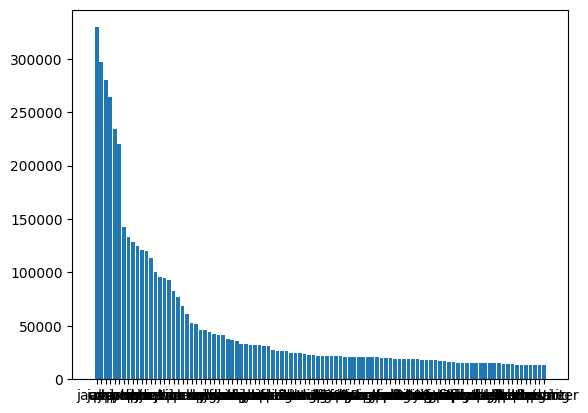

In [28]:
tags = dict(counter.most_common())
plt.bar(range(len(tags)), list(tags.values()), tick_label=list(tags.keys()))
plt.show()

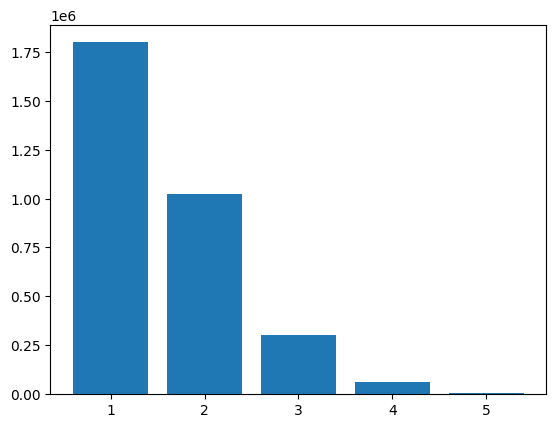

In [29]:
value_counts = df['Tags'].apply(lambda x : str(len(x)))
counter2 = Counter()
_ = value_counts.apply(counter2.update)
tags_length=dict(counter2)
plt.bar(range(len(tags_length)), list(tags_length.values()), tick_label=list(tags_length.keys()))
plt.show()

<BarContainer object of 4 artists>

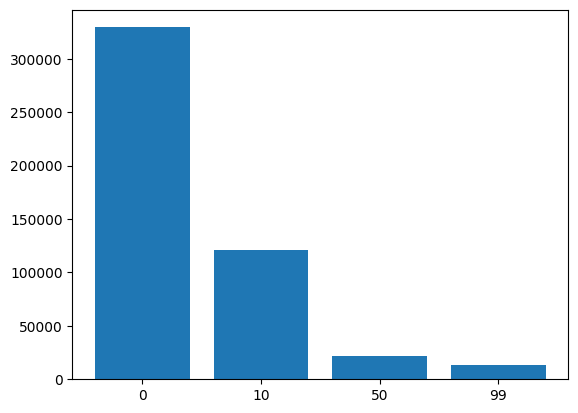

In [30]:
keys = [0,10,50,99]
values = []

x = list(counter.most_common(100))
for i in keys:
    values.append(x[i][1])
    
plt.bar(range(len(values)), values, tick_label=keys)

In [31]:
text_counter = Counter()
_ = df['Text'].apply(text_counter.update)
print("No. of unique words present in processed train data = ",len(text_counter))

No. of unique words present in processed train data =  3781199


In [38]:
text_counter

Counter({'use': 1607895,
         'id': 235967,
         'extens': 36514,
         'type': 206534,
         'jpeg': 3617,
         'uploadifi': 816,
         'bmp': 1272,
         'someth': 361744,
         'imag': 185720,
         'matter': 38261,
         'gif': 3448,
         'upload': 50975,
         'anoth': 248743,
         'problem': 547057,
         'way': 667053,
         'im': 847223,
         'uploadi': 205,
         'file': 540877,
         'check': 195720,
         'eg': 68000,
         'png': 9808,
         'mime': 2450,
         'php': 197855,
         'apart': 8299,
         'without': 235647,
         'textoct': 1,
         'jpg': 4890,
         'give': 204180,
         'chang': 350196,
         'like': 914104,
         'action': 61839,
         'certain': 71445,
         'activ': 77861,
         'quit': 67056,
         'regularli': 2744,
         'prevent': 42526,
         'press': 50050,
         'think': 222551,
         'happen': 135000,
         'favorit': 2635,
 

In [32]:
more_stopwords = ['use', 'get', 'like', 'work', 'want', 'im', 'need', 'way', 
                  'one', 'ive', 'dont', 'thank', 'doesnt', 'cant', 'would','know',
                  'help','seem','see','also', 'someth', 'exampl', 'first', 'follow', 'question',
                  'eg', 'give', 'think', 'happen', 'often', 'there', 'given', 'take']

# I am not able to use
# This doesnot work
# I did like this
# thanks for your help
# please see above appraoch
# cant find why it is failing
# I am missing something here
# For Example, this is the approach

In [33]:
df['Text'] = df['Text'].progress_apply(lambda x: [item for item in x if item not in more_stopwords])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3190940/3190940 [00:49<00:00, 64062.11it/s]


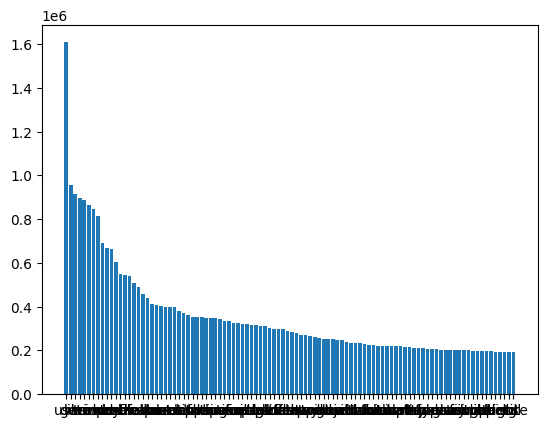

In [34]:
text = dict(text_counter.most_common(100))
plt.bar(range(len(text)), list(text.values()), tick_label=list(text.keys()))
plt.show()

In [39]:
text_counter = Counter()
_ = df['Text'].apply(text_counter.update)
print("No. of unique words present in processed train data = ",len(text_counter))

No. of unique words present in processed train data =  3781166


In [40]:
text_counter

Counter({'id': 235967,
         'extens': 36514,
         'type': 206534,
         'jpeg': 3617,
         'uploadifi': 816,
         'bmp': 1272,
         'imag': 185720,
         'matter': 38261,
         'gif': 3448,
         'upload': 50975,
         'anoth': 248743,
         'problem': 547057,
         'uploadi': 205,
         'file': 540877,
         'check': 195720,
         'png': 9808,
         'mime': 2450,
         'php': 197855,
         'apart': 8299,
         'without': 235647,
         'textoct': 1,
         'jpg': 4890,
         'chang': 350196,
         'action': 61839,
         'certain': 71445,
         'activ': 77861,
         'quit': 67056,
         'regularli': 2744,
         'prevent': 42526,
         'press': 50050,
         'favorit': 2635,
         'editor': 20210,
         'vim': 3549,
         'ctrlw': 18,
         'execut': 122342,
         'still': 194581,
         'firefox': 44264,
         'close': 67848,
         'stop': 67512,
         'window': 232846,

In [46]:
# x = list(dict(text_counter).keys())
y = [item for item in x if len(item)>15]

In [47]:
len(y)

1285329

In [43]:
y

['dataframestructur',
 'stringhttpwwwgooglecomsearchhlenampqc',
 'outputhttpwwwgooglecomsearchhlenampqc+objectsim',
 'mesagepleas',
 'createdefault',
 'intellisens',
 'httpwebrequest',
 'helpthanksamanda',
 'datastructur',
 'serializerdo',
 'motivationtimeskil',
 'reflectorani',
 'notsorandomoh',
 'goodcontext',
 'appropriatethen',
 'controllerbonu',
 'thoughtswhat',
 'thisliblocfusrflibfrflibraryversionprioritydependsimportslinkingtosuggestsenhancesostypelicensearchsbuiltrdsand',
 'datacontext',
 'therehttpsgithubcomgreenlawplaygreenscriptth',
 'simplexmlloadstr',
 'canceledsplit',
 'followingconvert',
 'enumparsecast',
 'enumerationth',
 'integerconvert',
 'approachexampl',
 'applicationi',
 'assemblymachin',
 'specifyingrend',
 'extensionless',
 'imagesexcept',
 'entityframework',
 'expressionhow',
 'permittederror',
 'currentviewsourceif',
 'baseviewmod',
 'currentviewsourc',
 'baseviewmodeland',
 'sint+etsint',
 'templatemeta',
 'followingthi',
 'objcclasstest',
 'otherlinkerflagi